### Import libraries

In [2781]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import augmentation as aug
import os

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


### Set seed for reproducibility

In [2871]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Define the folder where to save the model, the scaler, information about the training phase and the confusion matrix

In [2872]:
dir = 'fcn_final'

if not os.path.exists(dir):
    os.makedirs(dir)

ds_dir = 'dataset_per_class'

# load the dataset for class x
x=np.load(os.path.join(ds_dir, '7.npy'))

np.random.shuffle(x)

print(x.shape)

(68, 36, 6)


In [2874]:
from sklearn.model_selection import train_test_split

# split the dataset, change the train_size according to the class the autoencoder is trained on
x_train, x_val = train_test_split(x, train_size=0.6, random_state=seed)

print(x_train.shape)
print(x_val.shape)


(40, 36, 6)
(28, 36, 6)


In [2875]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# fit standard scaler on training set, then apply it on training and validation sets
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)


In [ ]:
# save the scaler into folder
import joblib
joblib.dump(scaler, os.path.join(dir, 'scaler.gz'))

# Perform data augmentation only if the class is an heavily minority class, making it 8 times bigger

In [2876]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# apply jitter on the dataset
jitter_train = aug.jitter(x_train, sigma=0.01)
x_train = np.append(x_train, jitter_train, axis=0)

# apply magnitude warp on the dataset
mag_warp_train = aug.magnitude_warp(x_train, sigma=0.2)
x_train = np.append(x_train, mag_warp_train, axis=0)

# apply scaling on the
scale_train = aug.scaling(x_train, sigma=0.075)
x_train = np.append(x_train, scale_train, axis=0)

input_shape = 216

['fcn_final\\scaler.gz']

# Define utilities to plot data augmentation

In [2877]:
def plot1d(x, x2=None, x3=None, ylim=(-1, 1), save_file=""):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 3))
    steps = np.arange(x.shape[0])
    plt.plot(steps, x)
    if x2 is not None:
        plt.plot(steps, x2)
    if x3 is not None:
        plt.plot(steps, x3)
    plt.xlim(0, x.shape[0])
    plt.ylim(ylim)
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, "")
    else:
        plt.show()
    return

In [2880]:
def show_plot(ds, sample_index, feature_index, augmented_ds=None):

    sample = ds[sample_index, :, feature_index]

    x_sample_max = np.max(sample)
    x_sample_min = np.min(sample)

    if augmented_ds is not None:
        augmented_sample = augmented_ds[sample_index, :, feature_index]
        aug_max = np.max(augmented_sample)
        aug_min = np.min(augmented_sample)
        max_range = aug_max if aug_max > x_sample_max else x_sample_max
        min_range = aug_min if aug_min < x_sample_min else x_sample_min
    else:
        max_range = x_sample_max
        min_range = x_sample_min



    print('looking at feature n.' + str(feature_index)
            + ' of sample n.' + str(sample_index))

    if augmented_ds is not None:
        plot1d(sample, augmented_sample, ylim=(min_range, max_range))
    else:
        plot1d(sample, ylim=(min_range, max_range))

looking at feature n.2 of sample n.10


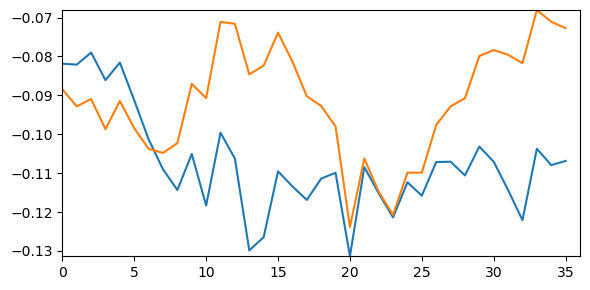

looking at feature n.2 of sample n.10


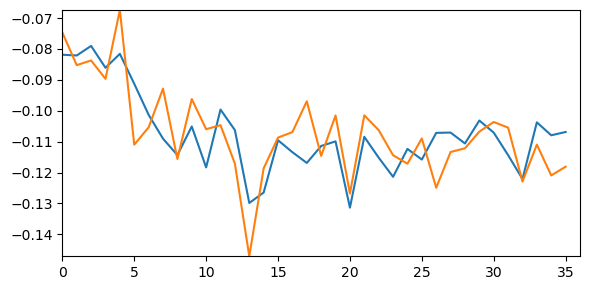

looking at feature n.2 of sample n.10


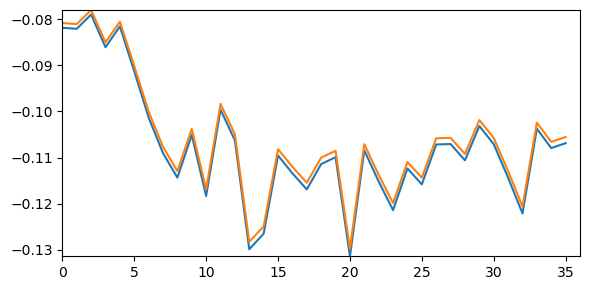

In [2890]:
x_try = x_train
sample_index = 10
feature_index = 2

show_plot(x_try, sample_index, feature_index, mag_warp_train)
show_plot(x_try, sample_index, feature_index, jitter_train)
show_plot(x_try, sample_index, feature_index, scale_train)


# Reshape each sample of the dataset from 36x6 to 216 and print information to check correctness

In [2891]:
x_try = x_train

print(x_train[0])
x_train = x_train.reshape((x_train.shape[0], -1, 1))
print(x_train[0])

x_val = x_val.reshape((x_val.shape[0], -1, 1))

batch_size = 8
epochs = 1000

[[0.12 -0.11 -0.12 -0.13 -0.23 -0.15]
 [0.17 -0.14 -0.11 -0.12 -0.25 -0.21]
 [-0.37 -0.07 -0.12 -0.13 -0.25 -0.25]
 [-0.07 -0.09 -0.12 -0.13 -0.20 -0.26]
 [-0.16 -0.08 -0.12 -0.14 -0.26 -0.15]
 [-0.07 -0.09 -0.12 -0.12 -0.26 -0.14]
 [0.15 -0.10 -0.11 -0.13 -0.26 -0.15]
 [0.24 -0.10 -0.12 -0.14 -0.27 -0.24]
 [0.04 -0.13 -0.12 -0.13 -0.22 -0.11]
 [-0.11 -0.08 -0.12 -0.14 -0.19 -0.15]
 [0.20 -0.09 -0.11 -0.13 -0.21 -0.24]
 [0.06 -0.09 -0.12 -0.13 -0.25 -0.11]
 [0.17 -0.10 -0.12 -0.13 -0.25 -0.21]
 [-0.03 -0.07 -0.12 -0.13 -0.24 -0.23]
 [-0.01 -0.09 -0.11 -0.13 -0.25 -0.22]
 [-0.08 -0.11 -0.11 -0.14 -0.26 -0.17]
 [-0.10 -0.07 -0.12 -0.14 -0.22 -0.14]
 [-0.05 -0.07 -0.11 -0.15 -0.29 -0.15]
 [-0.03 -0.07 -0.11 -0.13 -0.23 -0.26]
 [0.05 -0.08 -0.11 -0.13 -0.31 -0.38]
 [-0.05 -0.07 -0.11 -0.13 -0.22 -0.07]
 [0.12 -0.15 -0.12 -0.15 -0.30 -0.14]
 [-0.10 -0.19 -0.10 -0.12 -0.24 -0.21]
 [0.02 -0.10 -0.12 -0.13 -0.31 -0.28]
 [0.20 -0.09 -0.11 -0.13 -0.08 -0.09]
 [0.28 0.17 0.18 0.15 1.09 0.72]
 [-0

In [2892]:
x_train = x_train.squeeze(axis=2)
print(x_train[0])
x_val = x_val.squeeze(axis=2)

[0.12 -0.11 -0.12 -0.13 -0.23 -0.15 0.17 -0.14 -0.11 -0.12 -0.25 -0.21
 -0.37 -0.07 -0.12 -0.13 -0.25 -0.25 -0.07 -0.09 -0.12 -0.13 -0.20 -0.26
 -0.16 -0.08 -0.12 -0.14 -0.26 -0.15 -0.07 -0.09 -0.12 -0.12 -0.26 -0.14
 0.15 -0.10 -0.11 -0.13 -0.26 -0.15 0.24 -0.10 -0.12 -0.14 -0.27 -0.24
 0.04 -0.13 -0.12 -0.13 -0.22 -0.11 -0.11 -0.08 -0.12 -0.14 -0.19 -0.15
 0.20 -0.09 -0.11 -0.13 -0.21 -0.24 0.06 -0.09 -0.12 -0.13 -0.25 -0.11
 0.17 -0.10 -0.12 -0.13 -0.25 -0.21 -0.03 -0.07 -0.12 -0.13 -0.24 -0.23
 -0.01 -0.09 -0.11 -0.13 -0.25 -0.22 -0.08 -0.11 -0.11 -0.14 -0.26 -0.17
 -0.10 -0.07 -0.12 -0.14 -0.22 -0.14 -0.05 -0.07 -0.11 -0.15 -0.29 -0.15
 -0.03 -0.07 -0.11 -0.13 -0.23 -0.26 0.05 -0.08 -0.11 -0.13 -0.31 -0.38
 -0.05 -0.07 -0.11 -0.13 -0.22 -0.07 0.12 -0.15 -0.12 -0.15 -0.30 -0.14
 -0.10 -0.19 -0.10 -0.12 -0.24 -0.21 0.02 -0.10 -0.12 -0.13 -0.31 -0.28
 0.20 -0.09 -0.11 -0.13 -0.08 -0.09 0.28 0.17 0.18 0.15 1.09 0.72 -0.20
 0.18 0.19 0.17 0.90 0.43 0.12 0.05 0.05 0.01 0.31 0.26 0.09 -0

In [2893]:
print(x_train.shape)
print(x_val.shape)

(320, 216)
(28, 216)


### Build and train models

In [2894]:
# Change parameters based on the class in order not to overfit/underfit it
def generate_model(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    # ae = tfkl.Dense(input_shape, activation="elu")(input_layer)
    # ae = tfkl.Dropout(0.3)(ae)
    ae = tfkl.Dense(184, activation="elu")(input_layer)
    ae = tfkl.Dropout(0.3)(ae)
    # ae = tfkl.Dense(54, activation="elu")(ae)
    # ae = tfkl.Dropout(0.2)(ae)
    # ae = tfkl.Dense(10, activation="elu")(ae)
    # ae = tfkl.Dropout(0.2)(ae)
    # ae = tfkl.Dense(54, activation="elu")(ae)
    # ae = tfkl.Dropout(0.3)(ae)
    # ae = tfkl.Dense(108, activation="elu")(ae)
    ae = tfkl.Dense(input_shape, activation="linear")(ae)

    #MAYBE ADD AN BATCH NORMALIZATION:... to try!!
    output_layer = ae

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    # Return the model
    return model

In [2895]:
model = generate_model(input_shape)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 216)]             0         
                                                                 
 dense_502 (Dense)           (None, 184)               39928     
                                                                 
 dropout_188 (Dropout)       (None, 184)               0         
                                                                 
 dense_503 (Dense)           (None, 216)               39960     
                                                                 
Total params: 79,888
Trainable params: 79,888
Non-trainable params: 0
_________________________________________________________________


In [2897]:
model.compile(loss=tfk.losses.MeanAbsoluteError(), optimizer=tfk.optimizers.Adam())#, metrics=['mae_loss'])

In [2898]:
# Train the model
history = model.fit(
    x = x_train,
    y = x_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, x_val),
    shuffle=True,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=25, factor=0.5, min_lr=1e-15)
    ]
).history

Epoch 1/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4873 - val_loss: 0.4220 - lr: 0.0010
Epoch 2/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3361 - val_loss: 0.3872 - lr: 0.0010
Epoch 3/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.2793 - val_loss: 0.3677 - lr: 0.0010
Epoch 4/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.2497 - val_loss: 0.3535 - lr: 0.0010
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.2255 - val_loss: 0.3444 - lr: 0.0010
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.2147 - val_loss: 0.3368 - lr: 0.0010
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1973 - val_loss: 0.3307 - lr: 0.0010
Epoch 8/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1911 - val_loss: 0.3219 - lr: 0.0010
Epoch 9/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1834 - val_loss: 0.3

KeyboardInterrupt: 

# Plot loss and learning rate decay information during the training phase

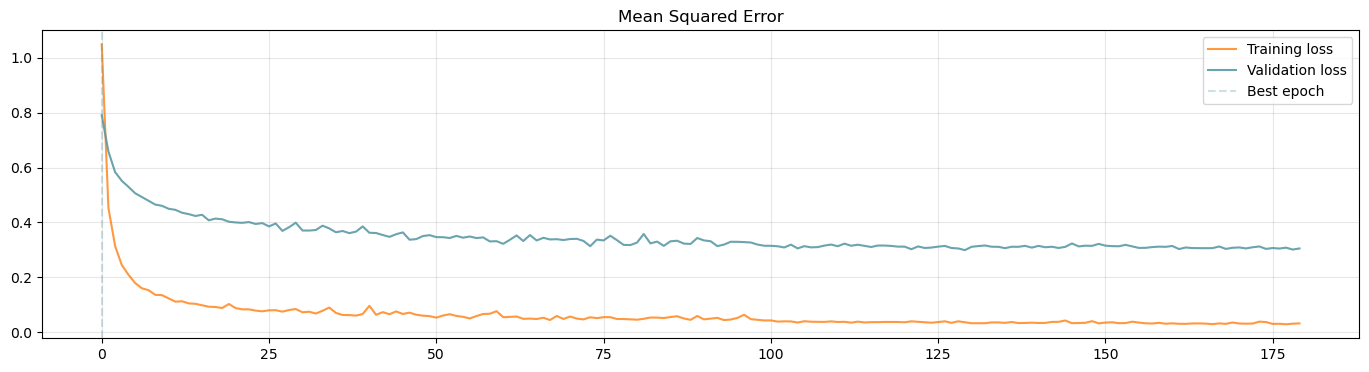

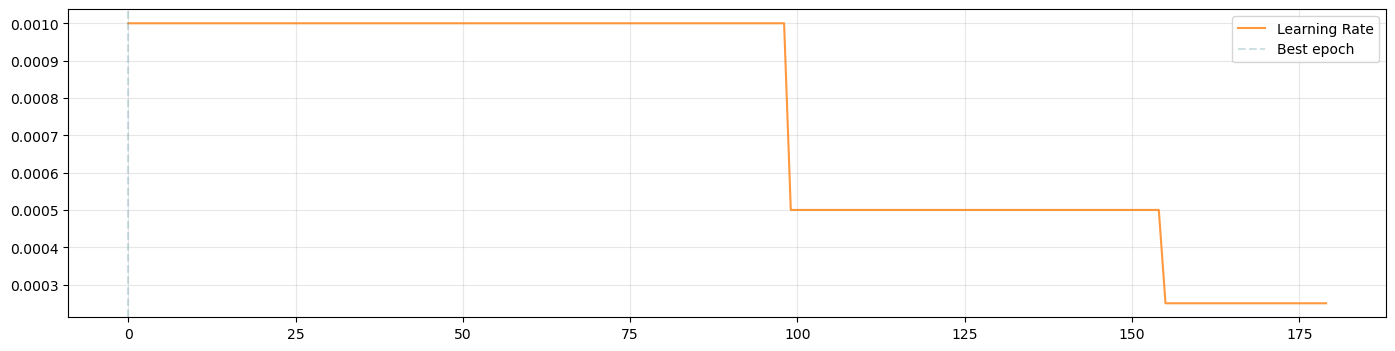

In [2802]:
best_epoch = np.argmax(history['val_loss'])
fig = plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()
fig.savefig(os.path.join(dir, 'cat_loss_train_val.png'), bbox_inches='tight')


plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()
fig.savefig(os.path.join(dir, 'lr_train_val.png'), bbox_inches='tight')


# Plot the quality of the autoencoder to predict samples of the right and wrong class

(28, 216) <class 'numpy.ndarray'>
looking at feature n.0 of sample n.2


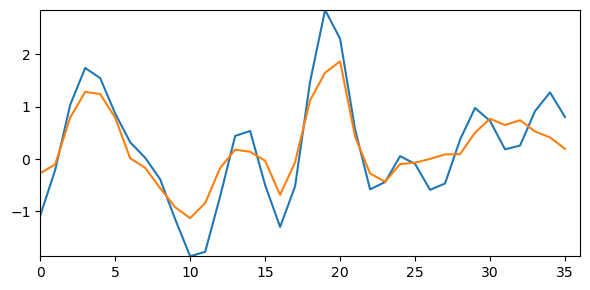

(28, 216) <class 'numpy.ndarray'>
looking at feature n.1 of sample n.2


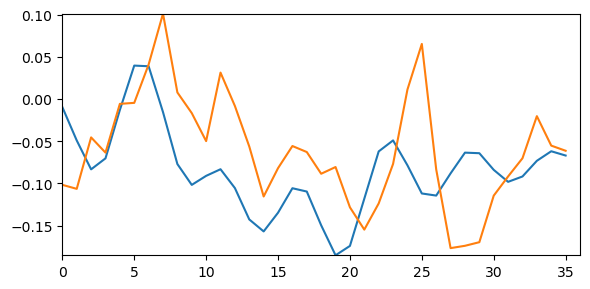

(28, 216) <class 'numpy.ndarray'>
looking at feature n.2 of sample n.2


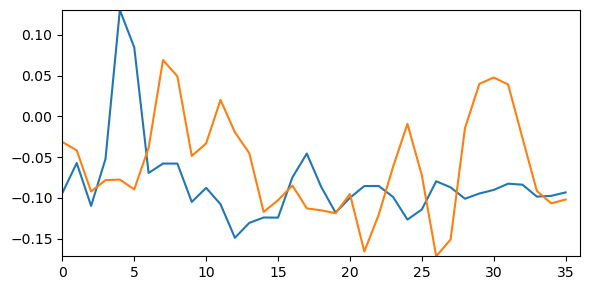

(28, 216) <class 'numpy.ndarray'>
looking at feature n.3 of sample n.2


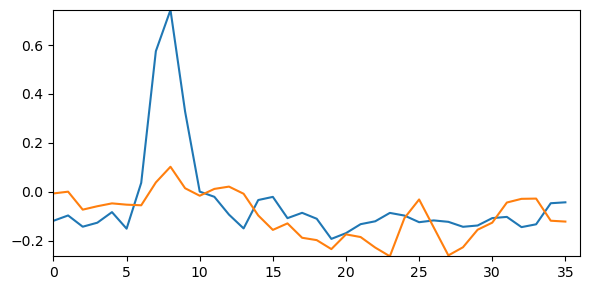

(28, 216) <class 'numpy.ndarray'>
looking at feature n.4 of sample n.2


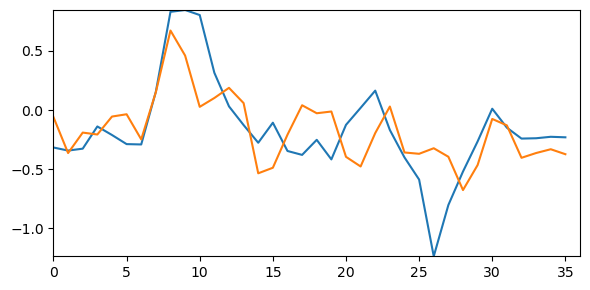

(28, 216) <class 'numpy.ndarray'>
looking at feature n.5 of sample n.2


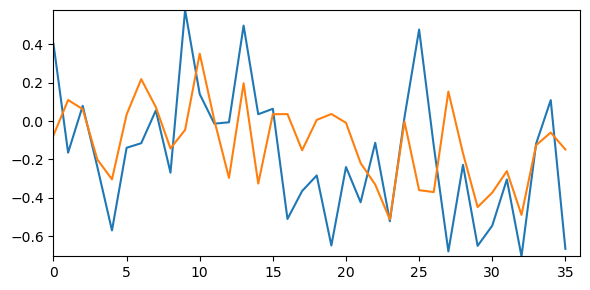

In [2838]:
x_wrong = np.load(os.path.join(ds_dir, '1.npy'))
x_wrong = scaler.transform(x_wrong.reshape(-1, x_wrong.shape[-1])).reshape(x_wrong.shape)
x_wrong = x_wrong.reshape((x_wrong.shape[0], -1, 1))
x_wrong = x_wrong.squeeze(axis=2)

for i in range(6):

    pred = model.predict(x_val, verbose=0)
    print(pred.shape, type(pred))
    series = np.reshape(x_val, (-1, 36, 6))
    pred_series = np.reshape(pred, (-1, 36, 6))
    show_plot(series, 2, i, augmented_ds=pred_series)

In [2803]:
# save the model if it is ok
model.save(os.path.join(dir, 'autoencoder_9'))

INFO:tensorflow:Assets written to: autoencoder_test-16-12\autoencoder_9\assets


INFO:tensorflow:Assets written to: autoencoder_test-16-12\autoencoder_9\assets
